In [5]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from fg_model import *
from SEDfitting import *

### Beam-convolved foregrounds
(Using Mel's model)

In [6]:
freq_list = np.arange(55.0, 85.0+0.5, 0.5)

# Load the RHINO wet soil beam
horn_wet = RhinoBeam(filepath='/Users/zzhang/Downloads/HornWet/')
horn_wet.get_beam_l()
beam_window = horn_wet.bl_list

# Generate the beam convolved Mel maps
Mel_model = SynchrotronExtrapolator()
mel_sky_RHINO_convolved = Mel_model.map(freq_list, beam_window)

### Timestream of the zenith  
LSTs → (RA, Dec) → Galactic (l, b) → HEALPix pixel index

In [7]:
from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time
import astropy.units as u
import healpy as hp

# === JBO site ===
lat = 53.23625  # degrees
lon = -2.30744  # degrees
location = EarthLocation(lat=lat*u.deg, lon=lon*u.deg)

# === Generate obs_time list（UTC）===
# From 2024-10-01 22:00 to 2024-10-02 04:00，every "delta_minutes" minute
start_time = Time('2024-10-01 22:00:00', scale='utc', location=location)
end_time   = Time('2024-10-02 04:00:00', scale='utc', location=location)
delta_minutes = 2

# Construct the time sequence
times = start_time + np.arange(0, (end_time - start_time).to_value('min') + delta_minutes, delta_minutes) * u.min

# === Calculate the corresponding LSTs ===
lst_array = times.sidereal_time('mean', longitude=lon*u.deg)

# === Constants ===
nside = 512  # HEALPix resolution
lat = 53.23625  # JBO latitude in degrees

# === Step 1: LSTs → (RA, Dec) for zenith ===
# Dec of zenith = latitude
dec_zenith = lat * u.deg
ra_zeniths = lst_array.to(u.deg)  # LST is the RA of the zenith

# === Step 2: Convert to Galactic coordinates ===
skycoords_eq = SkyCoord(ra=ra_zeniths, dec=dec_zenith, frame='icrs')
skycoords_gal = skycoords_eq.galactic

# === Step 3: Convert to HEALPix pixel indices ===
# Use vector representation to feed into healpy
vecs = skycoords_gal.represent_as('cartesian').get_xyz().value  # shape: (3, N)
pix_indices = hp.vec2pix(nside, vecs[0], vecs[1], vecs[2])

# === Example output ===
for time, lst, pix in zip(times[:5], lst_array[:5], pix_indices[:5]):
    print(f"UTC: {time.iso} | LST: {lst.to_string(unit=u.hour)} | HEALPix pixel: {pix}")


UTC: 2024-10-01 22:00:00.000 | LST: 22h35m15.91468459s | HEALPix pixel: 1691211
UTC: 2024-10-01 22:02:00.000 | LST: 22h37m16.24323363s | HEALPix pixel: 1697357
UTC: 2024-10-01 22:04:00.000 | LST: 22h39m16.57178268s | HEALPix pixel: 1699406
UTC: 2024-10-01 22:06:00.000 | LST: 22h41m16.90033172s | HEALPix pixel: 1705552
UTC: 2024-10-01 22:08:00.000 | LST: 22h43m17.22888076s | HEALPix pixel: 1707601


### Generate RHINO timestream of data (foreground components only)
shape: (n_LST, n_freqs)

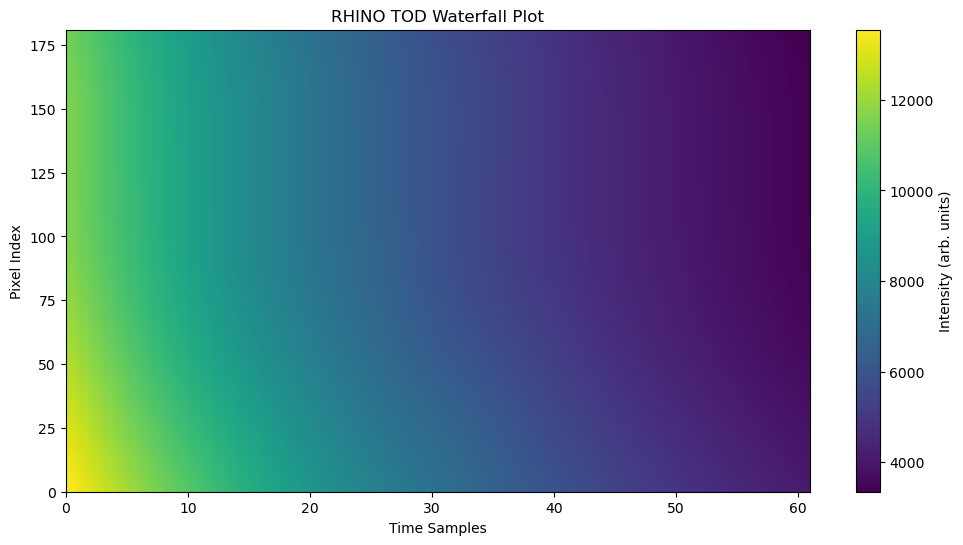

In [8]:
RHINO_tod = mel_sky_RHINO_convolved[pix_indices, :]
spec_ind_tod = Mel_model.specidx_map[pix_indices]

# Present the waterfall of the RHINO_tod
plt.figure(figsize=(12, 6))
plt.imshow(RHINO_tod, aspect='auto', origin='lower', 
           extent=[0, RHINO_tod.shape[1], 0, RHINO_tod.shape[0]])
plt.xlabel('Time Samples')
plt.ylabel('Pixel Index')
plt.colorbar(label='Intensity (arb. units)')
plt.title('RHINO TOD Waterfall Plot')
plt.show()

### Fitting RHINO TOD (foregrounds components)

In [9]:
mel_sky_RHINO_convolved.shape

coeffs_tod_fixed, loss_tod_fixed = fit_entire_map(RHINO_tod, spec_ind_tod, freq_list, nu_ref=None, max_order=6, fixed_pivot=True)
coeffs_tod_adapted, loss_tod_adapted = fit_entire_map(RHINO_tod, spec_ind_tod, freq_list, nu_ref=None, max_order=6, fixed_pivot=False)

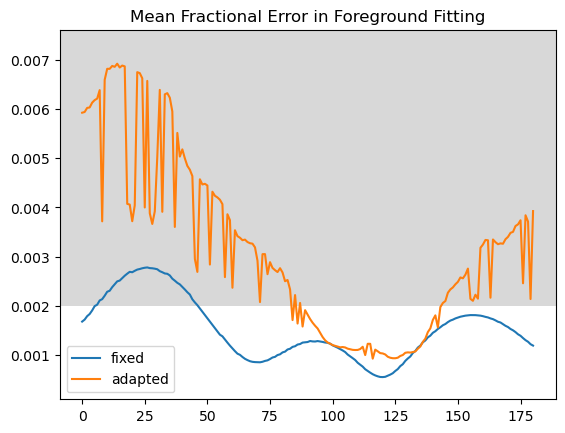

In [10]:
plt.plot(loss_tod_fixed, label='fixed')
plt.plot(loss_tod_adapted, label='adapted')
# Set the region above 0.002 to be gray
plt.gca().axhspan(ymin=0.002, ymax=1, facecolor='gray', alpha=0.3)
plt.ylim(0.0001, 1.1*np.max(loss_tod_adapted))
plt.title('Mean Fractional Error in Foreground Fitting')
plt.legend()

In [11]:
# Average neighbor 10 LSTs in RHINO_tod:
import numpy as np

window_size = 41  # -5 to +5 inclusive (11 elements total)
windows = np.lib.stride_tricks.sliding_window_view(RHINO_tod, (window_size,), axis=0)
RHINO_tod_rolling_average = windows.mean(axis=-1)

In [12]:
coeffs_roll_avrg_tod_fixed, loss_roll_avrg_tod_fixed = fit_entire_map(RHINO_tod_rolling_average, spec_ind_tod, freq_list, nu_ref=None, max_order=6, fixed_pivot=True)
coeffs_roll_avrg_tod_adapted, loss_roll_avrg_tod_adapted = fit_entire_map(RHINO_tod_rolling_average, spec_ind_tod, freq_list, nu_ref=None, max_order=6, fixed_pivot=False)

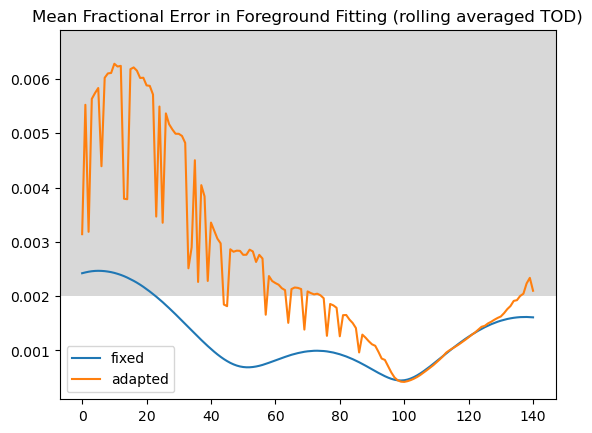

In [13]:
plt.plot(loss_roll_avrg_tod_fixed, label='fixed')
plt.plot(loss_roll_avrg_tod_adapted, label='adapted')
# Set the region above 0.002 to be gray
plt.gca().axhspan(ymin=0.002, ymax=1, facecolor='gray', alpha=0.3)
plt.ylim(0.0001, 1.1*np.max(loss_roll_avrg_tod_adapted))
plt.title('Mean Fractional Error in Foreground Fitting (rolling averaged TOD)')
plt.legend()

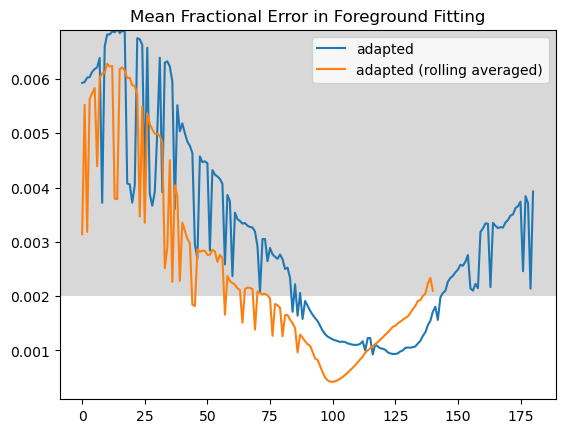

In [14]:


plt.plot(loss_tod_adapted, label='adapted')
plt.plot(loss_roll_avrg_tod_adapted, label='adapted (rolling averaged)')
# Set the region above 0.002 to be gray
plt.gca().axhspan(ymin=0.002, ymax=1, facecolor='gray', alpha=0.3)
plt.ylim(0.0001, 1.1*np.max(loss_roll_avrg_tod_adapted))
plt.title('Mean Fractional Error in Foreground Fitting')
plt.legend()

## Applying Beam Correction Functions

In [ ]:
ref_beam_window = horn_wet.bl_list[30]
ref_map = Mel_model.map(freq_list[30])
BCF_cube = np.array(horn_wet.generate_BCF(ref_map, ref_beam_window))

In [21]:
RHINO_tod_BCF = mel_sky_RHINO_convolved[pix_indices, :] / BCF_cube[pix_indices, :]


In [27]:
_, loss_tod_BCF_adapted = fit_entire_map(RHINO_tod_BCF, spec_ind_tod, freq_list, nu_ref=None, max_order=6, fixed_pivot=False)

In [51]:
window_size = 51  # -5 to +5 inclusive (11 elements total)
windows = np.lib.stride_tricks.sliding_window_view(RHINO_tod_BCF, (window_size,), axis=0)
RHINO_tod_BCF_rolling_average = windows.mean(axis=-1)

_, loss_tod_BCF_rolling_avrg_adapted = fit_entire_map(RHINO_tod_BCF_rolling_average, spec_ind_tod, freq_list, nu_ref=None, max_order=6, fixed_pivot=False)

In [52]:
# Get the indices where loss_tod_BCF_adapted is less than 5*10^-4

inx = np.where(loss_tod_BCF_adapted < 5*10**-4)[0]
mean_SED = np.mean(RHINO_tod_BCF[inx], axis=0)
mean_beta0 = np.mean(spec_ind_tod[inx], axis=0)
_, loss_tod_BCF_mean = fit_entire_map(np.array([mean_SED]), np.array([mean_beta0]), freq_list, nu_ref=None, max_order=6, fixed_pivot=False)

In [53]:
loss_tod_BCF_mean

array([0.00030405])

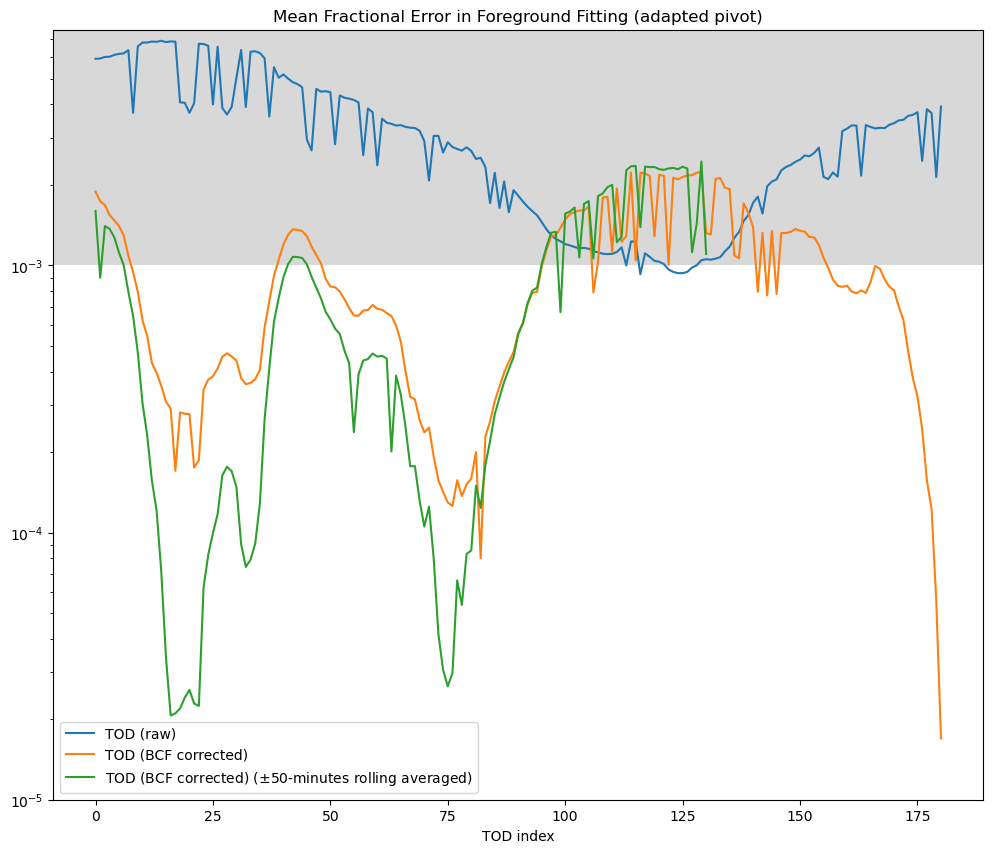

In [56]:
# Figure size:
plt.figure(figsize=(12, 10))

plt.plot(loss_tod_adapted, label='TOD (raw)')
plt.plot(loss_tod_BCF_adapted, label='TOD (BCF corrected)')
plt.plot(loss_tod_BCF_rolling_avrg_adapted, label=r'TOD (BCF corrected) ($\pm 50$-minutes rolling averaged)')
# Set the region above 0.002 to be gray
plt.gca().axhspan(ymin=0.001, ymax=1, facecolor='gray', alpha=0.3)
plt.ylim(0.00001, 1.1*np.max(loss_tod_adapted))
plt.yscale('log')
plt.xlabel('TOD index')
plt.title('Mean Fractional Error in Foreground Fitting (adapted pivot)')
plt.legend()

In [24]:
pix_indices

array([1691211, 1697357, 1699406, 1705552, 1707601, 1711699, 1715796,
       1719894, 1723991, 1726041, 1730139, 1734236, 1738334, 1740383,
       1742433, 1748578, 1750628, 1754726, 1756775, 1758825, 1764970,
       1767020, 1769069, 1773167, 1775217, 1777266, 1779316, 1783414,
       1785463, 1787513, 1789562, 1793660, 1795710, 1797759, 1797761,
       1799811, 1803909, 1805958, 1808008, 1808010, 1810059, 1812109,
       1814158, 1814160, 1818258, 1820308, 1820310, 1822359, 1824409,
       1824411, 1826460, 1826462, 1828512, 1828514, 1830563, 1830565,
       1830566, 1830568, 1832618, 1832620, 1834669, 1834671, 1834673,
       1834674, 1834676, 1834678, 1836728, 1836730, 1834683, 1836733,
       1836735, 1834688, 1834690, 1834692, 1834693, 1834695, 1834697,
       1832651, 1832653, 1830606, 1830608, 1828562, 1830611, 1828565,
       1828567, 1826520, 1826522, 1824476, 1824478, 1822431, 1820385,
       1820387, 1816293, 1814246, 1814248, 1812202, 1810155, 1808109,
       1808111, 1806

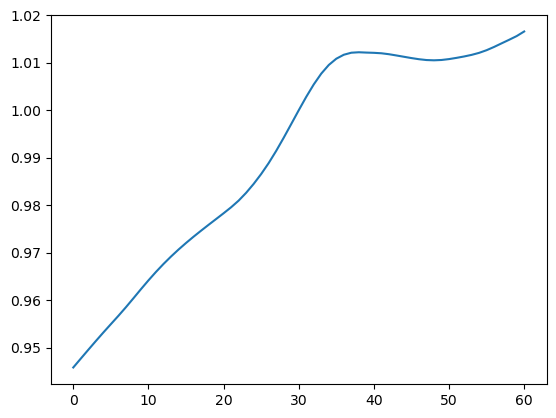

In [26]:
plt.plot(BCF_cube[1691211, :])